In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la
import pylab as pl

# Load the aggregated adjacency matrices

In [79]:
contact_adj_mat_files = ['output/temporally_aggregate_matrices/contact/agg_mat_InVS13.npy',
                         'output/temporally_aggregate_matrices/contact/agg_mat_InVS15.npy',
                         'output/temporally_aggregate_matrices/contact/agg_mat_LH10.npy',
                         'output/temporally_aggregate_matrices/contact/agg_mat_LyonSchool.npy',
                         'output/temporally_aggregate_matrices/contact/agg_mat_SFHH.npy',
                         'output/temporally_aggregate_matrices/contact/agg_mat_Thiers13.npy']

copresence_adj_mat_files = ['output/temporally_aggregate_matrices/co-presence/agg_mat_pres_InVS13.npy',
                            'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_InVS15.npy',
                            'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_LH10.npy',
                            'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_LyonSchool.npy',
                            'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_SFHH.npy',
                            'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_Thiers13.npy']

agg_mat_InVS13 = np.load(contact_adj_mat_files[0])
agg_mat_InVS15 = np.load(contact_adj_mat_files[1])
agg_mat_LH10 = np.load(contact_adj_mat_files[2])
agg_mat_LyonSchool = np.load(contact_adj_mat_files[3])
agg_mat_SFHH = np.load(contact_adj_mat_files[4])
agg_mat_Thiers13 = np.load(contact_adj_mat_files[5])

agg_mat_pres_InVS13 = np.load(copresence_adj_mat_files[0])
agg_mat_pres_InVS15 = np.load(copresence_adj_mat_files[1])
agg_mat_pres_LH10 = np.load(copresence_adj_mat_files[2])
agg_mat_pres_LyonSchool = np.load(copresence_adj_mat_files[3])
agg_mat_pres_SFHH = np.load(copresence_adj_mat_files[4])
agg_mat_pres_Thiers13 = np.load(copresence_adj_mat_files[5])

uw_agg_mat_InVS13 = agg_mat_InVS13
uw_agg_mat_InVS13[uw_agg_mat_InVS13 > 0] = 1
uw_agg_mat_InVS15 = agg_mat_InVS15
uw_agg_mat_InVS15[uw_agg_mat_InVS15 > 0] = 1
uw_agg_mat_LH10 = agg_mat_LH10
uw_agg_mat_LH10[uw_agg_mat_LH10 > 0] = 1
uw_agg_mat_LyonSchool = agg_mat_LyonSchool
uw_agg_mat_LyonSchool[uw_agg_mat_LyonSchool > 0] = 1
uw_agg_mat_SFHH = agg_mat_SFHH
uw_agg_mat_SFHH[uw_agg_mat_SFHH > 0] = 1
uw_agg_mat_Thiers13 = agg_mat_Thiers13
uw_agg_mat_Thiers13[uw_agg_mat_Thiers13 > 0] = 1

uw_agg_mat_pres_InVS13 = agg_mat_pres_InVS13
uw_agg_mat_pres_InVS13[uw_agg_mat_pres_InVS13 > 0] = 1
uw_agg_mat_pres_InVS15 = agg_mat_pres_InVS15
uw_agg_mat_pres_InVS15[uw_agg_mat_pres_InVS15 > 0] = 1
uw_agg_mat_pres_LH10 = agg_mat_pres_LH10
uw_agg_mat_pres_LH10[uw_agg_mat_pres_LH10 > 0] = 1
uw_agg_mat_pres_LyonSchool = agg_mat_pres_LyonSchool
uw_agg_mat_pres_LyonSchool[uw_agg_mat_pres_LyonSchool > 0] = 1
uw_agg_mat_pres_SFHH = agg_mat_pres_SFHH
uw_agg_mat_pres_SFHH[uw_agg_mat_pres_SFHH > 0] = 1
uw_agg_mat_pres_Thiers13 = agg_mat_pres_Thiers13
uw_agg_mat_pres_Thiers13[uw_agg_mat_pres_Thiers13 > 0] = 1

# Function definitions for global scale graph properties

In [80]:
def get_num_vertices(adj_mat):
    return adj_mat.shape[0]

def get_num_edges(adj_mat):
    n = get_num_vertices(adj_mat)
    upper_tri_idx = np.triu_indices(n, 1)
    return np.count_nonzero(adj_mat[upper_tri_idx])

def compute_graph_volume(adj_mat):
    return np.sum(adj_mat)

def compute_graph_density(adj_mat):
    n = get_num_vertices(adj_mat)
    m = get_num_edges(adj_mat)
    
    density = float(2 * m)/float(n * (n - 1))
    return density

In [81]:
get_num_vertices(agg_mat_InVS13)

100L

In [82]:
get_num_edges(agg_mat_InVS13)

755

In [83]:
compute_graph_volume(agg_mat_InVS13)

1510.0

In [84]:
compute_graph_density(agg_mat_InVS13)

0.15252525252525254

# Function definitions for local scale graph properties

In [90]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def compute_degree_distribution(adj_mat):
    # Assuming a simple, possibly weighted graph, degree of each vertex
    # will be the sum along one axis
    deg_arr = np.sum(adj_mat, axis=0)
    return deg_arr

def compute_unweighted_degree_distribution(adj_mat):
    adj_mat[adj_mat > 0] = 1
    deg_arr = np.sum(adj_mat, axis=0)
    return deg_arr

def compute_average_degree(adj_mat):
    deg_arr = compute_degree_distribution(adj_mat)
    n = get_num_vertices(adj_mat)
    
    avg_deg = float(sum(deg_arr))/float(n)
    return avg_deg

def display_degree_distribution(adj_mat, dataset_name, override_min=0, num_bins_log_log=50):
    deg_arr = compute_degree_distribution(adj_mat)
    #deg_arr = reject_outliers(deg_arr)
    # Display histogram of degree distribution
    plt.subplot(2, 1, 1)
    plt.hist(deg_arr, bins='auto')
    plt.title('Deg Dist of {}'.format(dataset_name))
    
    # Display histogram of degree distribution with log-log plot
    plt.subplot(2, 1, 2)
    max_val = np.amax(adj_mat)
    min_val = np.amin(adj_mat[adj_mat > override_min])
    print min_val
    pow_ten_min = 10 ** (np.floor(np.log10(min_val+0.1)))
    pow_ten_max = 10 ** (np.ceil(np.log10(max_val)))
    plt.hist(deg_arr, bins=np.logspace(np.log10(pow_ten_min), np.log10(pow_ten_max), num_bins_log_log))
    plt.gca().set_xscale('log')
    plt.title('Log-Log Deg Dist of {}'.format(dataset_name))
    
    plt.show()
    
def get_neighborhood_set_of_node(adj_mat, node):
    nbrhd = []
    n = get_num_vertices(adj_mat)
    
    # Find all edges connecting node to other nodes
    for j in range(0, n):
        if adj_mat[node][j] != 0:
            nbrhd.append(j)
    return nbrhd
    
def compute_clustering_coefficient(adj_mat, node):
    # Get the degree of the node
    node_deg = compute_unweighted_degree_distribution(adj_mat)[node]
    
    if node_deg <= 1:
        #print("Node {} has degree {}. CC is undefined".format(node, node_deg))
        return 0
    
    # Get the neighborhood set of the node
    nbrhd = get_neighborhood_set_of_node(adj_mat, node)
       
    # Get reduced neighborhood matrix of node
    nbrhd_matrix = adj_mat[:, nbrhd]
    nbrhd_matrix = nbrhd_matrix[nbrhd, :]
    nbrhd_matrix[nbrhd_matrix != 0] = 1
       
    # Count the number of triangles formed by the neighborhood set
    num_triangles = float(np.sum(nbrhd_matrix))/2.0

    # Compute the clustering coefficient and add it to the array
    clustering_coefficient = float(2 * num_triangles)/float(node_deg * (node_deg - 1))
    return clustering_coefficient
    
def compute_all_clustering_coefficients(adj_mat):
    # For each node in the graph, compute the clustering coefficient and store
    # it in an array
    n = get_num_vertices(adj_mat)
    cluster_coeff_arr = np.zeros((n, 1))
    
    for node in range(0, n):
        # Compute the clustering coefficient and add it to the array
        cluster_coeff_arr[node] = compute_clustering_coefficient(adj_mat, node)
        
    return cluster_coeff_arr    

def display_clustering_coefficient_dist(adj_mat, dataset_name, num_bins_log_log=50):
    cluster_coeff_arr = compute_all_clustering_coefficients(adj_mat)
    #cluster_coeff_arr = reject_outliers(cluster_coeff_arr)
    # Display histogram of clustering coefficients
    plt.subplot(2, 1, 1)
    plt.hist(cluster_coeff_arr, bins='auto')
    plt.title('CC Dist of {}'.format(dataset_name))
    
    # Display histogram of degree distribution with log-log plot
    plt.subplot(2, 1, 2)
    max_val = np.amax(cluster_coeff_arr)
    min_val = np.amin(cluster_coeff_arr)
    pow_ten_min = 10 ** (np.floor(np.log10(min_val+0.1)))
    pow_ten_max = 10 ** (np.ceil(np.log10(max_val)))
    plt.hist(deg_arr, bins=np.logspace(np.log10(pow_ten_min), np.log10(pow_ten_max), num_bins_log_log))
    plt.gca().set_xscale('log')
    plt.title('Log-Log CC Dist of {}'.format(dataset_name))
    
    plt.show()

def compute_average_clustering_coefficient(adj_mat):
    n = get_num_vertices(adj_mat)
    avg_cc = float(np.sum(compute_all_clustering_coefficients(adj_mat)))/float(n)
    return avg_cc
   

In [91]:
deg_arr = compute_degree_distribution(agg_mat_InVS13)
deg_arr

array([  0.,   0.,   7.,  16.,  15.,  24.,  12.,  25.,  13.,  21.,  21.,
        28.,   8.,  21.,  31.,   4.,   0.,  32.,  13.,  19.,  10.,  15.,
        19.,   9.,  21.,  22.,  11.,  26.,   0.,  17.,  14.,  30.,  22.,
        18.,  17.,  12.,  15.,  13.,  16.,  21.,   7.,  21.,  17.,  17.,
        18.,   4.,  18.,   7.,  25.,  28.,  15.,   6.,  16.,  20.,   0.,
        25.,  25.,  15.,  18.,   4.,  15.,  19.,  15.,  38.,  17.,   0.,
         0.,  17.,  15.,  13.,  10.,   9.,  21.,  11.,   6.,   6.,  16.,
        11.,  11.,  26.,  12.,  10.,  17.,  18.,  15.,  15.,  19.,  15.,
         0.,   8.,   7.,   4.,  44.,  15.,  26.,   9.,  26.,   5.,  15.,
        10.])

In [92]:
compute_average_degree(agg_mat_InVS13)

15.1

1.0


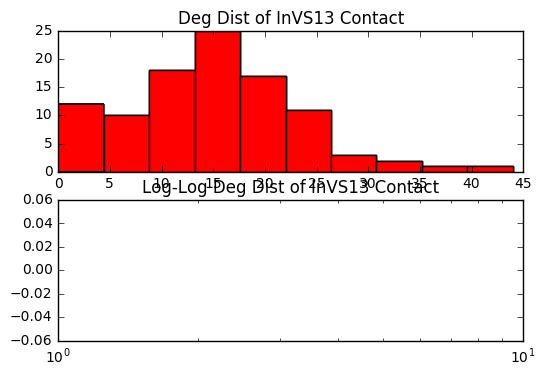

In [93]:
display_degree_distribution(agg_mat_InVS13, 'InVS13 Contact')

In [94]:
test_neighbors = get_neighborhood_set_of_node(agg_mat_InVS13, 22)
test_nbrhd_matrix = agg_mat_InVS13[:, test_neighbors]
test_nbrhd_matrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [95]:
compute_clustering_coefficient(agg_mat_InVS13, 22)

0.3391812865497076

In [96]:
compute_all_clustering_coefficients(agg_mat_InVS13)

array([[ 0.        ],
       [ 0.        ],
       [ 0.76190476],
       [ 0.6       ],
       [ 0.36190476],
       [ 0.35144928],
       [ 0.53030303],
       [ 0.34      ],
       [ 0.57692308],
       [ 0.50952381],
       [ 0.23809524],
       [ 0.25132275],
       [ 0.64285714],
       [ 0.32380952],
       [ 0.30537634],
       [ 0.16666667],
       [ 0.        ],
       [ 0.34274194],
       [ 0.51282051],
       [ 0.31578947],
       [ 0.33333333],
       [ 0.5047619 ],
       [ 0.33918129],
       [ 0.38888889],
       [ 0.29047619],
       [ 0.41125541],
       [ 0.47272727],
       [ 0.27076923],
       [ 0.        ],
       [ 0.34558824],
       [ 0.21978022],
       [ 0.28965517],
       [ 0.31601732],
       [ 0.39215686],
       [ 0.38970588],
       [ 0.25757576],
       [ 0.36190476],
       [ 0.61538462],
       [ 0.46666667],
       [ 0.37619048],
       [ 0.76190476],
       [ 0.41428571],
       [ 0.33823529],
       [ 0.41911765],
       [ 0.40522876],
       [ 0

In [97]:
compute_average_clustering_coefficient(agg_mat_InVS13)

0.3919492134683359

In [98]:
compute_average_clustering_coefficient(agg_mat_pres_LyonSchool)

0.9288944537680108

# Graph Comparison

-Compare contact and co-presence graphs using statistics

-Stats to compare: number of vertices, number of edges, volume, density, 
 degree distribution, average degree, clustering coefficient, avg CC

### Table of Statistics

In [99]:
single_stats = []

data = ['InVS13_contact']
A = agg_mat_InVS13
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['InVS13_copresence']
A = agg_mat_pres_InVS13
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['InVS15_contact']
A = agg_mat_InVS15
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['InVS15_copresence']
A = agg_mat_pres_InVS15
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['LH10_contact']
A = agg_mat_LH10
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['LH10_copresence']
A = agg_mat_pres_LH10
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['LyonSchool_contact']
A = agg_mat_LyonSchool
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['LyonSchool_copresence']
A = agg_mat_pres_LyonSchool
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['SFHH_contact']
A = agg_mat_SFHH
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['SFHH_copresence']
A = agg_mat_pres_SFHH
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['Thiers13_contact']
A = agg_mat_Thiers13
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

data = ['Thiers13_copresence']
A = agg_mat_pres_Thiers13
data.append(get_num_vertices(A))
data.append(get_num_edges(A))
data.append(compute_graph_volume(A))
data.append(compute_graph_density(A))
data.append(compute_average_degree(A))
data.append(compute_average_clustering_coefficient(A))
single_stats.append(data)

column_names = ['Dataset', 'Num Vertices', 'Num Edges', 'Volume',
                'Density', 'Avg Degree', 'Avg Clustering Coeff']
df = pd.DataFrame(single_stats, columns = column_names)

df


,Dataset,Num Vertices,Num Edges,Volume,Density,Avg Degree,Avg Clustering Coeff
0,InVS13_contact,100,755,1510.0,0.152525,15.100000,0.391949
1,InVS13_copresence,100,3915,7830.0,0.790909,78.300000,0.881436
2,InVS15_contact,232,4274,8548.0,0.159501,36.844828,0.356687
3,InVS15_copresence,232,16725,33450.0,0.624160,144.181034,0.754049
4,LH10_contact,81,1156,2312.0,0.356790,28.543210,0.636746
5,LH10_copresence,81,1381,2762.0,0.426235,34.098765,0.699436
6,LyonSchool_contact,242,8317,16634.0,0.285210,68.735537,0.525542
7,LyonSchool_copresence,242,26594,53188.0,0.911971,219.785124,0.928894
8,SFHH_contact,403,9565,19130.0,0.118082,47.468983,0.281761
9,SFHH_copresence,403,73557,147114.0,0.908077,365.047146,0.943835


### Degree Distributions and Clustering Coefficients

1.0


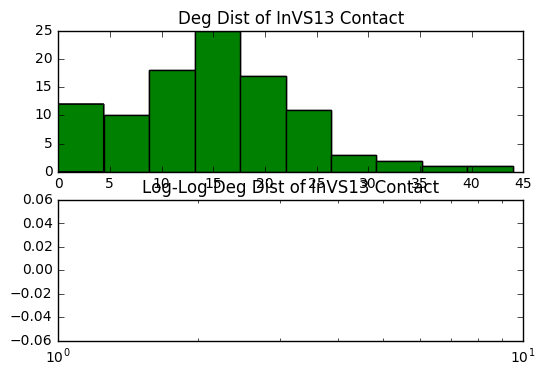

1.0


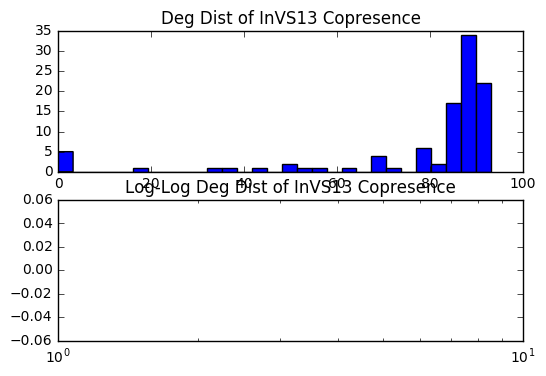

1.0


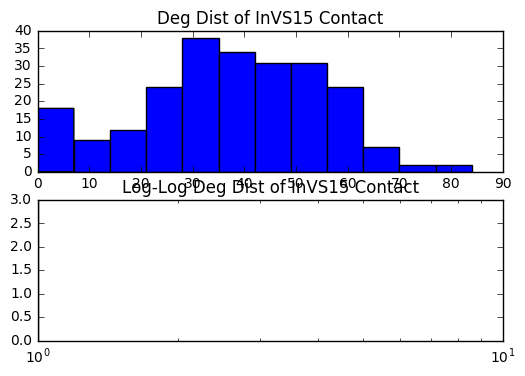

1.0


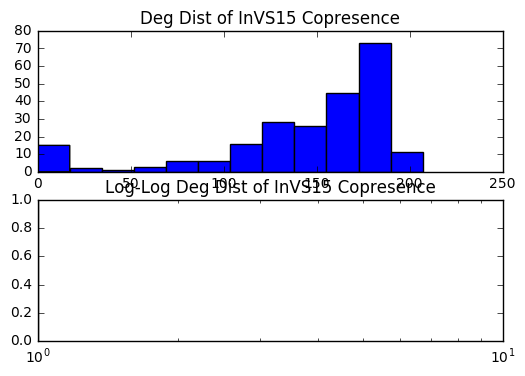

1.0


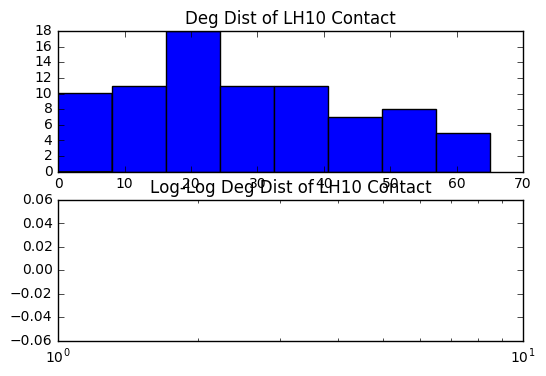

1.0


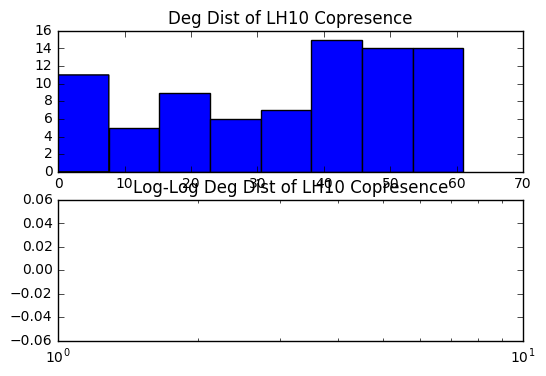

1.0


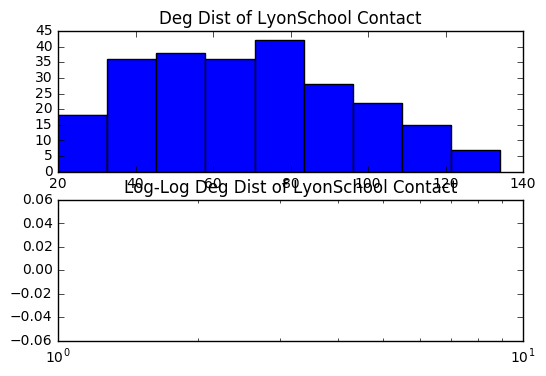

1.0


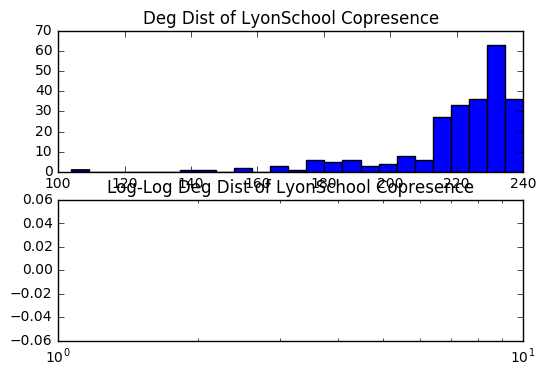

1.0


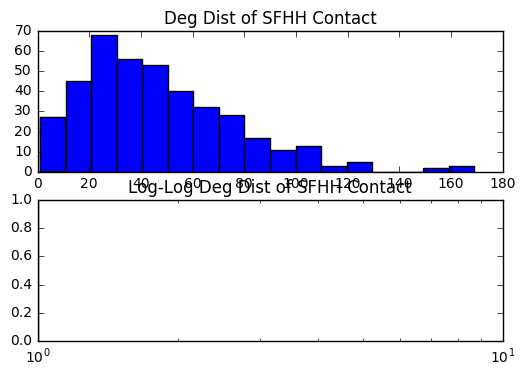

1.0


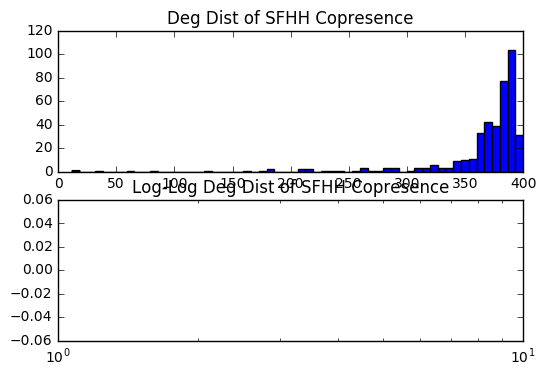

1.0


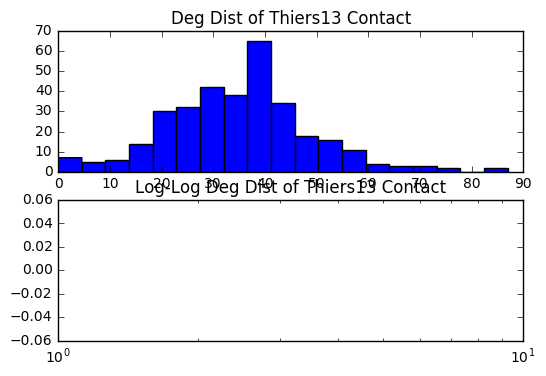

1.0


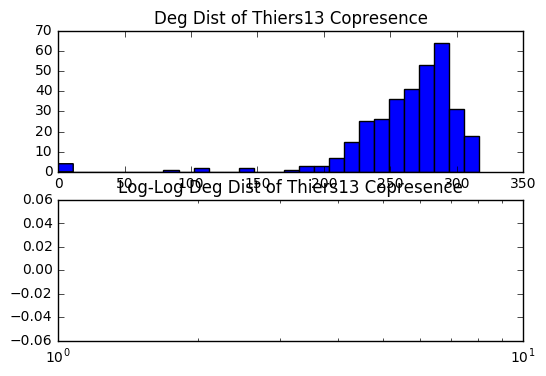

In [101]:
display_degree_distribution(uw_agg_mat_InVS13, 'InVS13 Contact')
display_degree_distribution(uw_agg_mat_pres_InVS13, 'InVS13 Copresence')
display_degree_distribution(uw_agg_mat_InVS15, 'InVS15 Contact')
display_degree_distribution(uw_agg_mat_pres_InVS15, 'InVS15 Copresence')
display_degree_distribution(uw_agg_mat_LH10, 'LH10 Contact')
display_degree_distribution(uw_agg_mat_pres_LH10, 'LH10 Copresence')
display_degree_distribution(uw_agg_mat_LyonSchool, 'LyonSchool Contact')
display_degree_distribution(uw_agg_mat_pres_LyonSchool, 'LyonSchool Copresence')
display_degree_distribution(uw_agg_mat_SFHH, 'SFHH Contact')
display_degree_distribution(uw_agg_mat_pres_SFHH, 'SFHH Copresence')
display_degree_distribution(uw_agg_mat_Thiers13, 'Thiers13 Contact')
display_degree_distribution(uw_agg_mat_pres_Thiers13, 'Thiers13 Copresence')

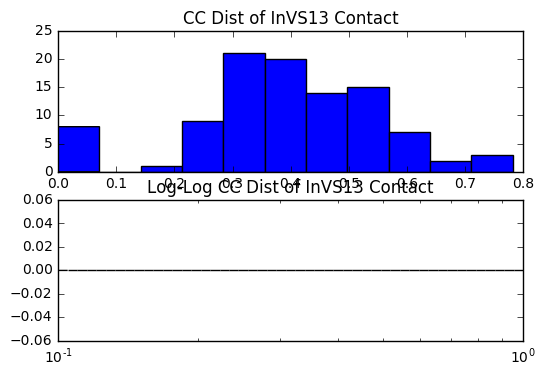

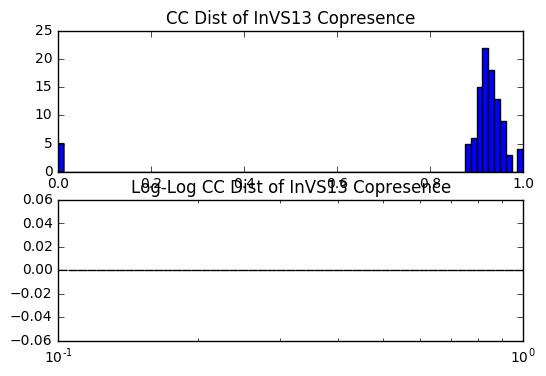

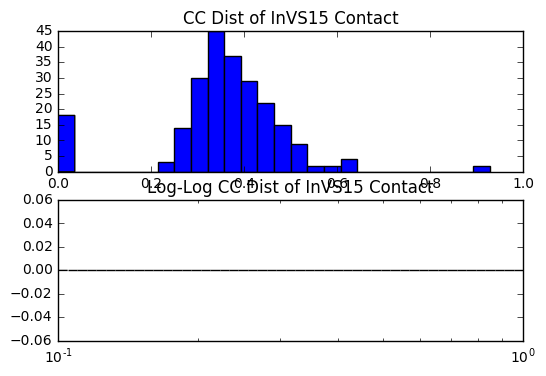

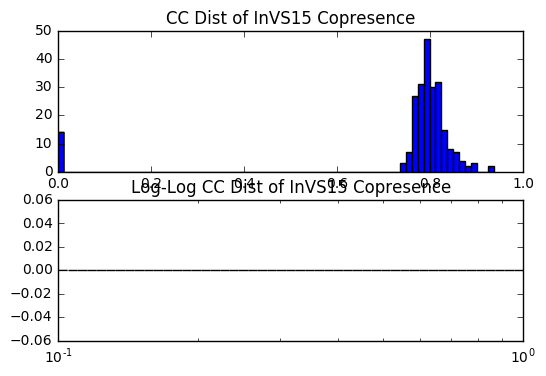

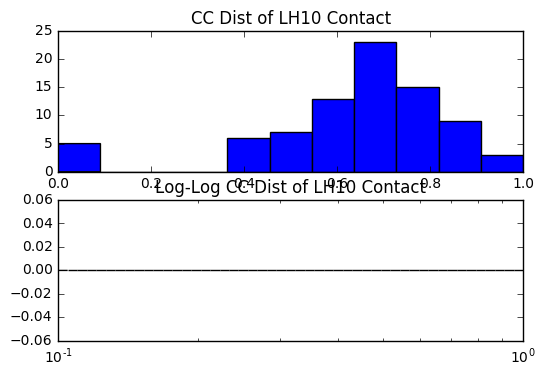

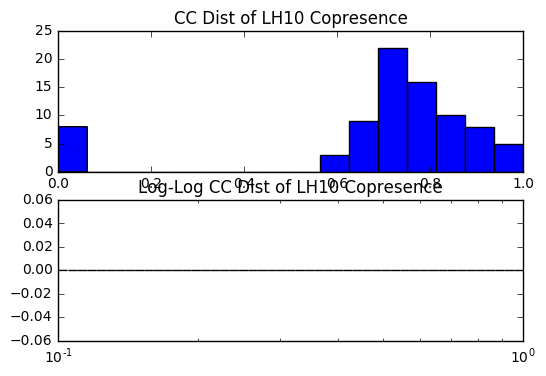

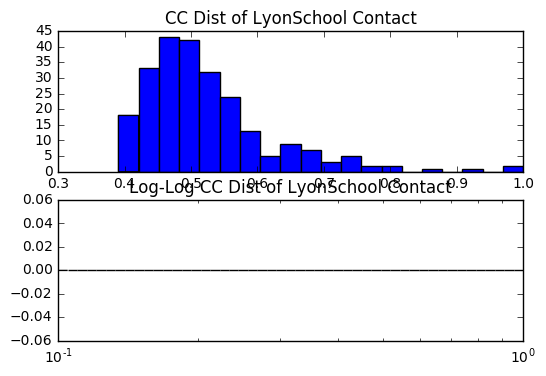

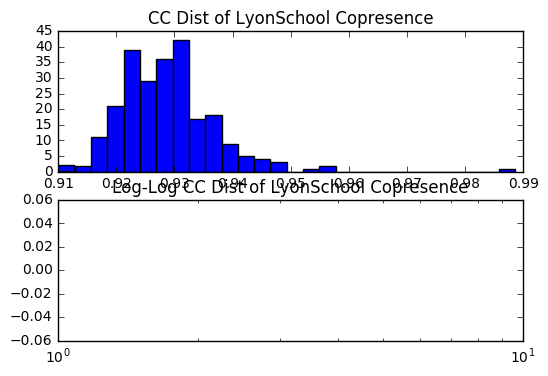

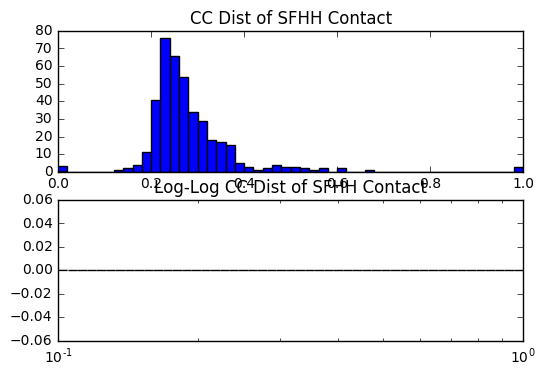

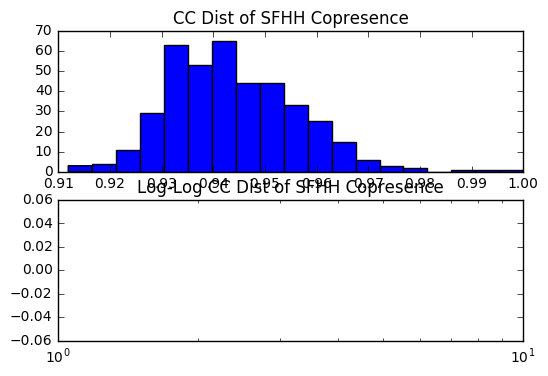

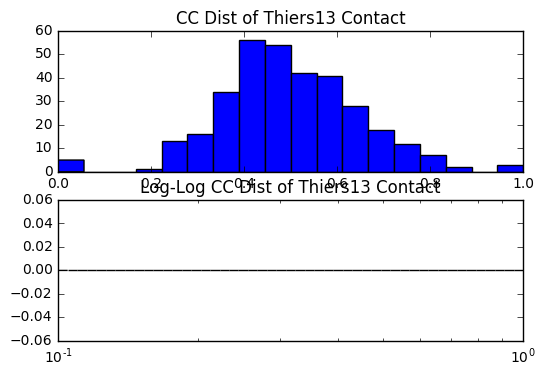

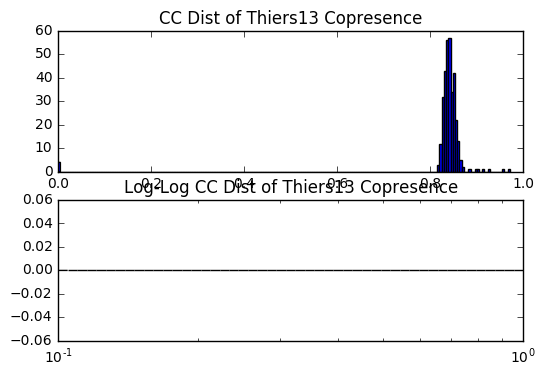

In [102]:
display_clustering_coefficient_dist(uw_agg_mat_InVS13, 'InVS13 Contact')
display_clustering_coefficient_dist(uw_agg_mat_pres_InVS13, 'InVS13 Copresence')
display_clustering_coefficient_dist(uw_agg_mat_InVS15, 'InVS15 Contact')
display_clustering_coefficient_dist(uw_agg_mat_pres_InVS15, 'InVS15 Copresence')
display_clustering_coefficient_dist(uw_agg_mat_LH10, 'LH10 Contact')
display_clustering_coefficient_dist(uw_agg_mat_pres_LH10, 'LH10 Copresence')
display_clustering_coefficient_dist(uw_agg_mat_LyonSchool, 'LyonSchool Contact')
display_clustering_coefficient_dist(uw_agg_mat_pres_LyonSchool, 'LyonSchool Copresence')
display_clustering_coefficient_dist(uw_agg_mat_SFHH, 'SFHH Contact')
display_clustering_coefficient_dist(uw_agg_mat_pres_SFHH, 'SFHH Copresence')
display_clustering_coefficient_dist(uw_agg_mat_Thiers13, 'Thiers13 Contact')
display_clustering_coefficient_dist(uw_agg_mat_pres_Thiers13, 'Thiers13 Copresence')

In [ ]:
plt.subplot(1, 2, 1)
plt.matshow(agg_mat_InVS13, fignum=False)
plt.title('InVS13 Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_InVS13, fignum=False)
plt.title('InVS13 Copresence')
plt.show()

plt.subplot(1, 2, 1)
plt.matshow(agg_mat_InVS15, fignum=False)
plt.title('InVS15 Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_InVS15, fignum=False)
plt.title('InVS15 Copresence')
plt.show()

plt.subplot(1, 2, 1)
plt.matshow(agg_mat_LH10, fignum=False)
plt.title('LH10 Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_LH10, fignum=False)
plt.title('LH10 Copresence')
plt.show()

plt.subplot(1, 2, 1)
plt.matshow(agg_mat_LyonSchool, fignum=False)
plt.title('LyonSchool Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_LyonSchool, fignum=False)
plt.title('LyonSchool Copresence')
plt.show()

plt.subplot(1, 2, 1)
plt.matshow(agg_mat_SFHH, fignum=False)
plt.title('SFHH Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_SFHH, fignum=False)
plt.title('SFHH Copresence')
plt.show()

plt.subplot(1, 2, 1)
plt.matshow(agg_mat_Thiers13, fignum=False)
plt.title('Thiers13 Contact')
plt.subplot(1, 2, 2)
plt.matshow(agg_mat_pres_Thiers13, fignum=False)
plt.title('Thiers13 Copresence')
plt.show()